In [1]:
setwd("H:/PS/Logistic_Regression")
adultCensus = read.csv("adultcensus.csv")


In [26]:
library(e1071)
library(stringr)
library(ggcorrplot)
library(stringi)
library(devtools)
library(InformationValue)
library(caret)
library(tidyverse)
library(caret)
library(ROCR)
options(scipen = 999)

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



In [4]:
#Check for missing data. The dataset has "?" question marks in place of missing values.
#This has been taken care of using the following:
#Getting rid of such records:
sapply(adultCensus, function(x) sum(is.na(x)))
#checking for each column:
#adultCensus = adultCensus[adultCensus$occupation != "?", ]

age      workclass         fnlwgt      education        edu_num 
             0              0              0              0              0 
marital_status     occupation   relationship           race            sex 
             0              0              0              0              0 
  capital.gain   capital.loss hours_per_week         Native   income_class 
             0              0              0              0              0

In [5]:
#Checking through all the columns:
No_ques_marks <- function(x, column){
  for (column in colnames(adultCensus)){
    print("?" %in% x[, column])
  }
}
No_ques_marks(adultCensus, colnames(adultCensus))

[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE


In [6]:
#Viewing data type of each column:
sapply(adultCensus, class)

age      workclass         fnlwgt      education        edu_num 
     "integer"       "factor"      "integer"       "factor"      "integer" 
marital_status     occupation   relationship           race            sex 
      "factor"       "factor"       "factor"       "factor"       "factor" 
  capital.gain   capital.loss hours_per_week         Native   income_class 
     "integer"      "integer"      "integer"       "factor"       "factor"

In [7]:
head(adultCensus)

age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,capital.gain,capital.loss,hours_per_week,Native,income_class
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [8]:
tail(adultCensus)

,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,capital.gain,capital.loss,hours_per_week,Native,income_class
38320,48,Local-gov,349230,Masters,14,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K.
38321,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
38322,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
38323,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
38324,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
38325,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


In [9]:
#Label Encoding for outcome variable:
unique(adultCensus$income_class)
adultCensus$income_class[adultCensus$income_class == "<=50K."] <- "<=50K"
adultCensus$income_class[adultCensus$income_class == ">50K."] <- ">50K"

[1] <=50K  >50K   <=50K. >50K. 
Levels: <=50K <=50K. >50K >50K.

In [10]:
adultCensus$class <- factor(adultCensus$income_class,
                   levels = c('<=50K','>50K'),
                   labels = c(0,1))
#Verifying that the outcome variable is binary
unique(adultCensus$class)

[1] 0 1
Levels: 0 1

,age,fnlwgt,capital.gain,capital.loss,hours_per_week
age,1.00000000,-0.075607324,0.076862188,0.05804258,0.10144964
fnlwgt,-0.07560732,1.000000000,-0.002882717,-0.00385697,-0.01569907
capital.gain,0.07686219,-0.002882717,1.000000000,-0.03185829,0.08508155
capital.loss,0.05804258,-0.003856970,-0.031858291,1.00000000,0.05567208
hours_per_week,0.10144964,-0.015699068,0.085081554,0.05567208,1.00000000


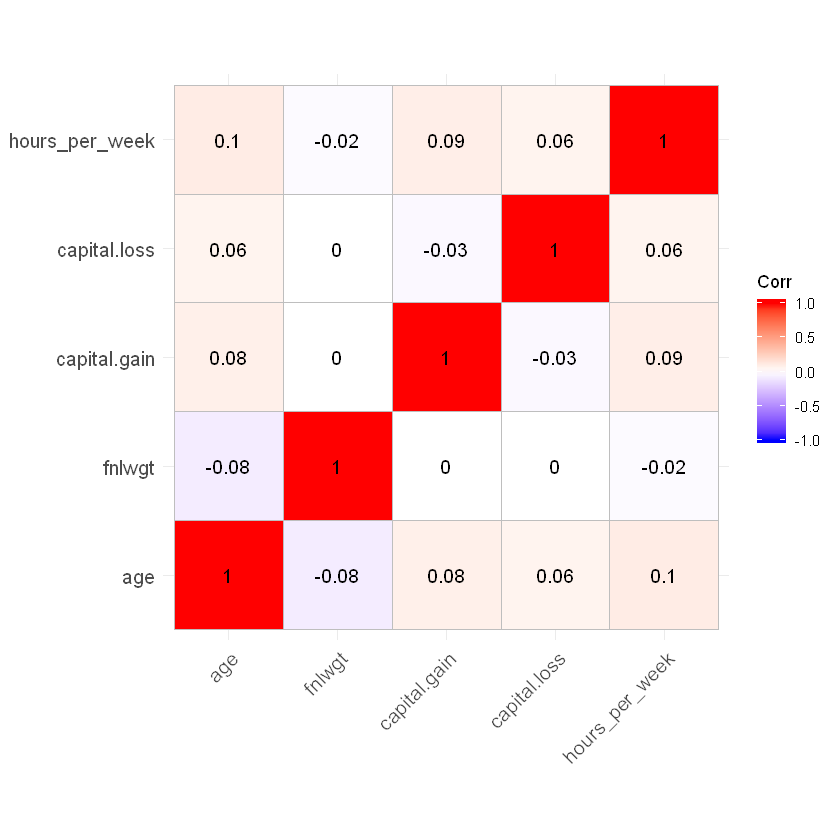

In [11]:
#Collecting only continuous variables:
acNumerical <- adultCensus[c(1,3,11,12,13)]
acNumerical <- scale(acNumerical)
acNumerical <- data.frame(acNumerical)
#Visualizing correlation amongst continuous variables:
acNum_cor <- cor(acNumerical)
acNum_cor
ggcorrplot(acNum_cor, lab = TRUE)

In [12]:
acNumerical$class <- adultCensus$class
#checking correlations with continuous variables
ConVar_cor <- manova(cbind(age, fnlwgt, capital.gain, capital.loss, hours_per_week) ~ class, data = acNumerical)
summary(ConVar_cor)
summary.aov(ConVar_cor)
#Thus, variable "fnlwgt" fails to have a significant impact on income class. We exclude this variable from our model

             Df  Pillai approx F num Df den Df                Pr(>F)    
class         1 0.14782   1329.3      5  38319 < 0.00000000000000022 ***
Residuals 38323                                                         
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Response age :
               Df Sum Sq Mean Sq F value                Pr(>F)    
class           1   2087 2086.80  2206.9 < 0.00000000000000022 ***
Residuals   38323  36237    0.95                                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Response fnlwgt :
               Df Sum Sq Mean Sq F value Pr(>F)
class           1      1  1.1361  1.1361 0.2865
Residuals   38323  38323  1.0000               

 Response capital.gain :
               Df Sum Sq Mean Sq F value                Pr(>F)    
class           1   1855 1854.68  1948.9 < 0.00000000000000022 ***
Residuals   38323  36469    0.95                                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Response capital.loss :
               Df Sum Sq Mean Sq F value                Pr(>F)    
class           1    830  829.80  848.14 < 0.00000000000000022 ***
Residuals   38323  37494    0.98                                  
---
Signif. codes:  0 '***' 0.0

In [15]:
#We first run the model with selected continuous and all categorical variables.
#Deleting edu_num as it is redundant, along with income_class and fnlwgt.
print("adultCensus:")
head(adultCensus,1)
ConVarScaled <- adultCensus[-c(3,5,15)]
print("ConVarScaled:")
head(ConVarScaled,1)
#Feature Scaling for continuous Variables:  
ConVarScaled[c(1,9,10,11)] = scale(ConVarScaled[c(1,9,10,11)])

[1] "adultCensus:"


age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,capital.gain,capital.loss,hours_per_week,Native,income_class,class
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0


[1] "ConVarScaled:"


age,workclass,education,marital_status,occupation,relationship,race,sex,capital.gain,capital.loss,hours_per_week,Native,class
39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0


In [16]:
model_All <- glm(formula = class ~ ., data = ConVarScaled, family = binomial ,control = list(maxit = 50))
summary(model_All)
#Checking Multi-collinearity by examining VIF values for Categorical Variables
car::vif(model_All)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = class ~ ., family = binomial, data = ConVarScaled, 
    control = list(maxit = 50))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9997  -0.5159  -0.1912  -0.0244   3.6125  

Coefficients:
                                     Estimate Std. Error z value
(Intercept)                          -4.59900    0.73554  -6.253
age                                   0.32571    0.01999  16.297
workclassLocal-gov                   -0.62508    0.10026  -6.235
workclassPrivate                     -0.47600    0.08372  -5.686
workclassSelf-emp-inc                -0.33914    0.10967  -3.092
workclassSelf-emp-not-inc            -1.01410    0.09804 -10.344
workclassState-gov                   -0.77512    0.11052  -7.013
workclassWithout-pay                 -0.96486    0.82880  -1.164
education11th                         0.01061    0.18716   0.057
education12th                         0.30219    0.24367   1.240
education1st-4th                     -0.47938    0.

,GVIF,Df,GVIF^(1/(2*Df))
age,1.239740,1,1.113436
workclass,1.618377,6,1.040934
education,2.100208,15,1.025043
marital_status,52.639305,6,1.391370
occupation,2.814006,13,1.040595
relationship,118.595740,5,1.612155
race,2.998412,4,1.147127
sex,2.877526,1,1.696327
capital.gain,1.032232,1,1.015988
capital.loss,1.014184,1,1.007067


In [17]:
#We need to remove the variable with highest GVIF, which is "relationship". 
ConVarScaled <- ConVarScaled[-c(6)]
model_All <- glm(formula = class ~ ., data = ConVarScaled, family = binomial ,control = list(maxit = 50))
summary(model_All)
#Checking Multi-collinearity by examining VIF values for Categorical Variables
car::vif(model_All)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = class ~ ., family = binomial, data = ConVarScaled, 
    control = list(maxit = 50))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0335  -0.5128  -0.2117  -0.0329   3.4453  

Coefficients:
                                      Estimate Std. Error z value
(Intercept)                          -3.872791   0.685097  -5.653
age                                   0.329334   0.019699  16.718
workclassLocal-gov                   -0.643367   0.099785  -6.448
workclassPrivate                     -0.473603   0.083450  -5.675
workclassSelf-emp-inc                -0.325284   0.109774  -2.963
workclassSelf-emp-not-inc            -0.997690   0.097932 -10.188
workclassState-gov                   -0.782248   0.110201  -7.098
workclassWithout-pay                 -1.060838   0.833643  -1.273
education11th                        -0.002403   0.187040  -0.013
education12th                         0.308632   0.243596   1.267
education1st-4th                     -0.

,GVIF,Df,GVIF^(1/(2*Df))
age,1.226619,1,1.107528
workclass,1.614666,6,1.040735
education,2.072599,15,1.024591
marital_status,1.548766,6,1.037127
occupation,2.775290,13,1.040041
race,2.973312,4,1.145922
sex,1.429731,1,1.195714
capital.gain,1.029595,1,1.014690
capital.loss,1.014040,1,1.006995
hours_per_week,1.120830,1,1.058692


In [18]:
Cat_vars <- c ("workclass", "education", "marital_status", "occupation", "race", "sex", "Native")
Cat_infoval <- data.frame(VARS=Cat_vars, IV=numeric(length(Cat_vars)), STRENGTH=character(length(Cat_vars)), stringsAsFactors = F)
for (Cat_var in Cat_vars){
  Cat_infoval[Cat_infoval$VARS == Cat_var, "IV"] <- InformationValue::IV(X=adultCensus[, Cat_var], Y=adultCensus$class)
  Cat_infoval[Cat_infoval$VARS == Cat_var, "STRENGTH"] <- attr(InformationValue::IV(X=adultCensus[, Cat_var], Y=adultCensus$class), "howgood")
}
Cat_infoval <- Cat_infoval[order(-Cat_infoval$IV), ]
Cat_infoval

,VARS,IV,STRENGTH
3,marital_status,1.32385744,Highly Predictive
4,occupation,0.74746648,Highly Predictive
2,education,0.71304603,Highly Predictive
6,sex,0.29981097,Highly Predictive
1,workclass,0.12423435,Highly Predictive
7,Native,0.08100767,Somewhat Predictive
5,race,0.06611061,Somewhat Predictive


In [20]:
#We would continue to include the bottom variables as well.
#Select significant features:
print("ConVarScaled:")
head(ConVarScaled,1)
Sig_Data <- ConVarScaled#[-c(6,11)] 

#Check class distribution
#Baseline accuracy:
table(adultCensus$class)

[1] "ConVarScaled:"


age,workclass,education,marital_status,occupation,race,sex,capital.gain,capital.loss,hours_per_week,Native,class
0.03042553,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,0.1413175,-0.2182684,-0.0770721,United-States,0



    0     1 
28875  9450 

In [21]:
#Baseline accuracy
baseline <- round(28875/nrow(adultCensus),2)
baseline

[1] 0.75

Our model accuracy should at least be 75%

In [22]:
#Split into training and testing:
set.seed(123)
training_samples <- Sig_Data$class %>% 
  createDataPartition(p = 0.70, list = FALSE)
train  <- Sig_Data[training_samples, ]
test <- Sig_Data[-training_samples, ]
head(test,1)

,age,workclass,education,marital_status,occupation,race,sex,capital.gain,capital.loss,hours_per_week,Native,class
6,-0.1202864,Private,Masters,Married-civ-spouse,Exec-managerial,White,Female,-0.1459554,-0.2182684,-0.0770721,United-States,0


In [23]:
#Applying model with selected features:
mod_sig <- glm(formula = class ~ ., data = train, family = binomial(link = "logit") ,control = list(maxit = 50))
summary(mod_sig)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = class ~ ., family = binomial(link = "logit"), data = train, 
    control = list(maxit = 50))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0485  -0.5161  -0.2116  -0.0327   3.2292  

Coefficients:
                                      Estimate Std. Error z value
(Intercept)                          -3.828946   0.780693  -4.905
age                                   0.338552   0.023513  14.398
workclassLocal-gov                   -0.572533   0.118621  -4.827
workclassPrivate                     -0.385670   0.099235  -3.886
workclassSelf-emp-inc                -0.229377   0.131352  -1.746
workclassSelf-emp-not-inc            -0.924385   0.116334  -7.946
workclassState-gov                   -0.699326   0.130795  -5.347
workclassWithout-pay                 -0.458583   0.877191  -0.523
education11th                        -0.125002   0.220935  -0.566
education12th                        -0.045352   0.306784  -0.148
education1st-4th               

AIC has reduced from 25290 to 17755

In [24]:
# Predicting the Test set results
pred_modsig = predict(mod_sig, type = 'response', newdata = test[-12])
#find optimal threshold:
library(InformationValue)
oc <- optimalCutoff(test$class, pred_modsig)[1] 
oc

[1] 0.51

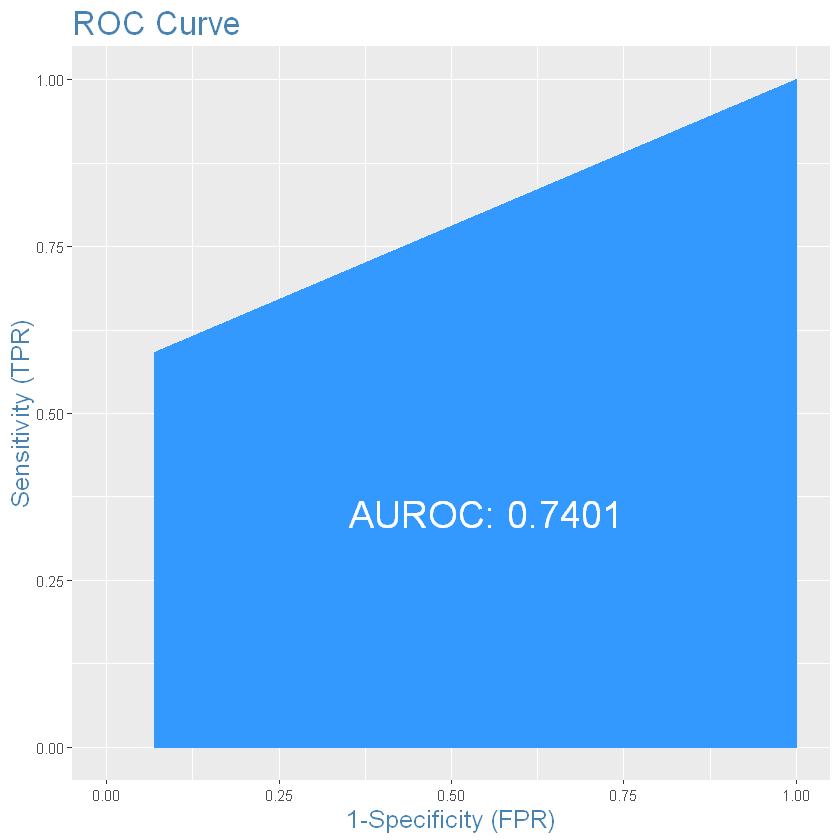

In [30]:
p_class_modsig = ifelse(pred_modsig > oc, 1, 0)
#roc.curve(test$class, p_class_modsig)
plotROC(test$class, p_class_modsig)

In [32]:
ypred <- as.data.frame(p_class_modsig)
sapply(ypred, class)

unique(ypred$p_class_modsig)
ypred$p_class_modsig <- factor(ypred$p_class_modsig,
                               levels = c('0','1'),
                               labels = c(0,1))
sapply(ypred, class)

p_class_modsig 
     "numeric"

[1] 1 0

p_class_modsig 
      "factor"

In [33]:
confusionMatrix(reference = test$class, data = ypred$p_class_modsig, positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8058 1159
         1  604 1676
                                               
               Accuracy : 0.8467               
                 95% CI : (0.8399, 0.8532)     
    No Information Rate : 0.7534               
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.5582               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.5912               
            Specificity : 0.9303               
         Pos Pred Value : 0.7351               
         Neg Pred Value : 0.8743               
             Prevalence : 0.2466               
         Detection Rate : 0.1458               
   Detection Prevalence : 0.1983               
      Balanced Accuracy : 0.7607               
                                               
       'Positive' Cl

The Model has performed better than the baseline Accuracy of 75% to now 84.67%.
However, the accuracy can be misleading when we have imabalanced classes.
Sensitivity has taken a hit, being at 0.5912
Specificity looks good at 0.9303
Precision would just be average at 0.7351

I would like to treat class imbalance and examine results for new training and testing set, and provide EDA as well.
This file will be updated.